# Baseline Model

Below we have the baseline model using an SVM network.

In [5]:
"""
Baseline Model - SVM
"""

import cv2
import numpy as np
import os

from sklearn import linear_model, metrics, svm 
from sklearn.model_selection import train_test_split

np.random.seed(0)
RANDOM_NUM = np.random.randint(1000)

ModuleNotFoundError: No module named 'cv2'

In [35]:
DATA_PATH = "KLARR_NET_data/fer_2013"

IMG_WIDTH = 48
IMG_HEIGHT = 48

def create_dataset(img_folder):
    """ Creates a dataset of the images in the given folder and returns the
    data and labels array.
    """
    img_data_array = []
    class_name = []
   
    for class_num, dir in enumerate(os.listdir(img_folder)):
        print(f"Class Num: {class_num}, Directory: {dir}")

        for i, filename in enumerate(os.listdir(os.path.join(img_folder, dir))):
            if i % 1000 == 0:
                print(i)

            # Read the image in grayscale
            image_path = os.path.join(img_folder, dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(
                image,
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_AREA
            )

            # Convert to numpy and normalize between 0 and 1
            image = np.array(image).astype('float32').flatten() / 255

            img_data_array.append(image)
            class_name.append(class_num)

    return np.array(img_data_array), np.array(class_name)

X_train, y_train = create_dataset(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    train_size=0.7,
    random_state=RANDOM_NUM)

Class Num: 0, Directory: angry
0


NameError: name 'cv2' is not defined

In [3]:
CLASSES = ['angry', 'fear', 'happy' ,'neutral' ,'sad' ,'surprise']

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

print(f"Baseline Model Training Set Size: {len(X_train)}")
print_class_distribution_in_dataset(y_train)

print(f"\nBaseline Model Test Set Size: {len(X_test)}")
print_class_distribution_in_dataset(y_test)


Baseline Model Training Set Size: 22405
Class: angry, Number of Classes: 3466
Class: fear, Number of Classes: 3532
Class: happy, Number of Classes: 3984
Class: neutral, Number of Classes: 4364
Class: sad, Number of Classes: 4252
Class: surprise, Number of Classes: 2807

Baseline Model Test Set Size: 9603
Class: angry, Number of Classes: 1451
Class: fear, Number of Classes: 1545
Class: happy, Number of Classes: 1801
Class: neutral, Number of Classes: 1822
Class: sad, Number of Classes: 1810
Class: surprise, Number of Classes: 1174


In [36]:
from joblib import dump, load
from pathlib import Path

MODELS_DIR = "models"

def train_and_test_baseline(model):
    """ Fits model to training data and prints information about its accuracy
    with respect to test data.
    """
    model.fit(X_train, y_train)

    # Test its accuracy on testing data
    y_pred = model.predict(X_test)
    classification_report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    baseline_test_acc = model.score(X_test, y_test)
    print(f"Baseline Model Test Accuracy: {baseline_test_acc}")

    print(f"Classification report for classifier {model}:")
    print(f"\n{classification_report}")

    print(f"\nConfusion matrix:\n\n{confusion_matrix}")

def save_baseline(model, name):
    file_name = f"baseline_model_{name}.joblib"
    model_location = os.path.join(MODELS_DIR, file_name)

    Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)
    dump(model, model_location)

    # To load the model, use this expression
    # clf = load(model_location)

In [5]:
baseline_model_1 = linear_model.SGDClassifier(
    loss='log',
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_1)

Baseline Model Test Accuracy: 0.28157867333125064
Classification report for classifier SGDClassifier(loss='log', n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.27      0.16      0.20      1451
           1       0.21      0.29      0.24      1545
           2       0.46      0.30      0.36      1801
           3       0.33      0.21      0.25      1822
           4       0.32      0.13      0.18      1810
           5       0.25      0.75      0.37      1174

    accuracy                           0.28      9603
   macro avg       0.30      0.31      0.27      9603
weighted avg       0.31      0.28      0.27      9603


Confusion matrix:

[[232 365 164 143 111 436]
 [123 444 102 150 101 625]
 [153 359 540 182 108 459]
 [129 374 170 377 152 620]
 [196 482 148 241 231 512]
 [ 40 129  42  57  26 880]]


In [6]:
baseline_model_2 = linear_model.SGDClassifier(
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_2)

bm2_params = baseline_model_2.get_params()
save_baseline(
    baseline_model_2,
    f"SGDClassifier_randomstate-{bm2_params['random_state']}"
)

Baseline Model Test Accuracy: 0.2869936478183901
Classification report for classifier SGDClassifier(n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.29      0.11      0.16      1451
           1       0.25      0.19      0.21      1545
           2       0.45      0.24      0.32      1801
           3       0.24      0.66      0.35      1822
           4       0.28      0.19      0.23      1810
           5       0.56      0.27      0.36      1174

    accuracy                           0.29      9603
   macro avg       0.35      0.28      0.27      9603
weighted avg       0.34      0.29      0.27      9603


Confusion matrix:

[[ 159  184  152  722  194   40]
 [  90  291   85  786  188  105]
 [  90  155  441  907  182   26]
 [  77  164  116 1210  213   42]
 [  95  230  127  983  343   32]
 [  31  156   55  532   88  312]]


In [7]:
baseline_model_3 = svm.LinearSVC(
    dual=False,
    C=100,
    max_iter=20,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_3)

bm3_params = baseline_model_3.get_params()
save_baseline(
    baseline_model_3,
    f"LinearSVC_dual-{bm3_params['dual']}_C-{bm3_params['C']}_"
    f"iters-{bm3_params['max_iter']}_randomstate-{bm3_params['random_state']}"
)

Baseline Model Test Accuracy: 0.32541913985212956
Classification report for classifier LinearSVC(C=100, dual=False, max_iter=20, random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.19      0.22      1451
           1       0.24      0.18      0.21      1545
           2       0.41      0.46      0.43      1801
           3       0.30      0.35      0.32      1822
           4       0.29      0.29      0.29      1810
           5       0.42      0.49      0.45      1174

    accuracy                           0.33      9603
   macro avg       0.32      0.33      0.32      9603
weighted avg       0.32      0.33      0.32      9603


Confusion matrix:

[[279 174 276 294 297 131]
 [187 277 223 306 288 264]
 [165 144 832 298 253 109]
 [174 198 288 642 352 168]
 [217 230 294 420 525 124]
 [ 79 111 141 169 104 570]]


In [9]:
baseline_model_4 = linear_model.SGDClassifier(
    n_jobs=-1,
    learning_rate='invscaling',
    eta0=0.005,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_4)

bm4_params = baseline_model_4.get_params()
save_baseline(
    baseline_model_4,
    f"SGDClassifier_lr-{bm4_params['learning_rate']}_eta0-{bm4_params['eta0']}_"
    f"randomstate-{bm4_params['random_state']}"
)

Baseline Model Test Accuracy: 0.3498906591690097
Classification report for classifier SGDClassifier(eta0=0.005, learning_rate='invscaling', n_jobs=-1,
              random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.24      0.25      1451
           1       0.28      0.10      0.15      1545
           2       0.40      0.59      0.48      1801
           3       0.32      0.50      0.39      1822
           4       0.33      0.24      0.27      1810
           5       0.52      0.40      0.45      1174

    accuracy                           0.35      9603
   macro avg       0.35      0.34      0.33      9603
weighted avg       0.35      0.35      0.33      9603


Confusion matrix:

[[ 346   72  368  381  202   82]
 [ 274  159  308  448  207  149]
 [ 177   62 1054  316  147   45]
 [ 176   82  356  910  231   67]
 [ 280   97  353  566  426   88]
 [ 116   90  168  255   80  465]]


# CNN Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch

from torchvision import datasets, transforms

np.random.seed(0)
torch.manual_seed(1000)
RANDOM_NUM = np.random.randint(1000)

In [2]:
CLASSES = None

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

In [3]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

DATA_PATH = "KLARR_NET_data/fer_2013"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    ])

total_data = datasets.ImageFolder(root=DATA_PATH, transform=TRANSFORM_IMG)
total_data_len = len(total_data)
CLASSES = total_data.classes

print('Number of Images : ', total_data_len)
print_class_distribution_in_dataset(total_data.targets)

Number of Images :  32012
Class: angry, Number of Classes: 4917
Class: fear, Number of Classes: 5081
Class: happy, Number of Classes: 5785
Class: neutral, Number of Classes: 6186
Class: sad, Number of Classes: 6062
Class: surprise, Number of Classes: 3981


In [4]:
train_data_len = int(total_data_len * 0.7)
valid_data_len = int(total_data_len * 0.15)
test_data_len = total_data_len - train_data_len - valid_data_len

train_data, valid_data, test_data = torch.utils.data.random_split(
    total_data,
    (train_data_len, valid_data_len, test_data_len)
)

print(f"Number of Training Images: {len(train_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in train_data])

print(f"\nNumber of Validation Images: {len(valid_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in valid_data])

print(f"\nNumber of Test Images: {len(test_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in test_data])


Number of Training Images: 22408
Class: angry, Number of Classes: 3452
Class: fear, Number of Classes: 3577
Class: happy, Number of Classes: 4053
Class: neutral, Number of Classes: 4254
Class: sad, Number of Classes: 4284
Class: surprise, Number of Classes: 2788

Number of Validation Images: 4801
Class: angry, Number of Classes: 733
Class: fear, Number of Classes: 743
Class: happy, Number of Classes: 885
Class: neutral, Number of Classes: 950
Class: sad, Number of Classes: 876
Class: surprise, Number of Classes: 614

Number of Test Images: 4803
Class: angry, Number of Classes: 732
Class: fear, Number of Classes: 761
Class: happy, Number of Classes: 847
Class: neutral, Number of Classes: 982
Class: sad, Number of Classes: 902
Class: surprise, Number of Classes: 579


In [5]:
import itertools

from datetime import datetime
from sklearn.metrics import confusion_matrix

USE_CUDA = torch.cuda.is_available()

def get_model_name(name, batch_size, learning_rate, iteration):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_iter{3}_date{4}".format(
      name,
      batch_size,
      learning_rate,
      iteration,
      datetime.now().strftime("%d_%m_%Y-%H_%M")
    )
    return path

def get_accuracy(model, data_loader, dropout=False):
    if(dropout):
        model.eval()
    correct, total = 0, 0

    for imgs, labels in data_loader:
      if USE_CUDA:
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = model(imgs)
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    if(dropout):
        model.train()
    return correct / total

def plot_confusion_matrix(
    model,
    data,
    title="Confusion Matrix",
    normalize=True,
    cmap=plt.cm.Blues
):
    classes = data.dataset.classes

    # Find true and predicted values for the given data
    y_pred = [None] * len(data)
    y_true = [None] * len(data)

    for i, index in enumerate(data.indices):
        X = data.dataset[index][0].unsqueeze(0)

        if USE_CUDA:
            X = X.cuda()

        y_pred[i] = classes[model(X).max(1, keepdim=True)[1].item()]
        y_true[i] = classes[data.dataset[index][1]]

    # Find confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot colourful confusion matrix
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

def train(
    model,
    train_data,
    val_data,
    batch_size=512,
    learning_rate=0.001,
    iterations=10,
    decay=0,
    dropout=False,
    save=True
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    train_loss, train_acc, val_acc = [], [], []

    train_loader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    for iteration in range(iterations):
        iter_loss = float(0)
        for imgs, labels in train_loader:
            if USE_CUDA:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_loss += float(loss.item())

        # Compute training/validation accuracy/loss
        train_loss.append(iter_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader, dropout=dropout))
        val_acc.append(get_accuracy(model, val_loader, dropout=dropout))

        # Save model progress
        if save:
            model_path = get_model_name(model.name, batch_size, learning_rate, iteration)
            torch.save(model.eval().state_dict(), f"models/{model_path}")

        print(("Iteration {}: Train loss: {}, Train accuracy: {}"
              " | Validation accuracy: {}").format(
                iteration + 1,
                train_loss[-1],
                train_acc[-1],
                val_acc[-1]
        ))

    # Plot model training information
    plt.title("Loss Curves")
    plt.plot(range(1, iterations+1), train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1, iterations+1), train_acc, label="Train")
    plt.plot(range(1, iterations+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    plot_confusion_matrix(model, valid_data, title="Model Confusion Matrix (Validation)")

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET(nn.Module):
    def __init__(self):
        super(KLARR_NET, self).__init__()
        self.name = 'KLARR_NET'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(9*9*10, 72)
        self.fc2 = nn.Linear(72, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Linear layers
        x = x.view(-1, 9*9*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [18]:
model1 = KLARR_NET()

if USE_CUDA:
    model1 = model1.cuda()

train(model1, train_data, valid_data, save=False)

NameError: name 'USE_CUDA' is not defined

Iteration 1: Train loss: 1.7105453353036533, Train accuracy: 0.3385398072117101 | Validation accuracy: 0.330764424078317
Iteration 2: Train loss: 1.5624916804107754, Train accuracy: 0.40454302034987505 | Validation accuracy: 0.39554259529264735
Iteration 3: Train loss: 1.4693786772814663, Train accuracy: 0.43457693680828274 | Validation accuracy: 0.4197042282857738
Iteration 4: Train loss: 1.4085327224297957, Train accuracy: 0.4504641199571582 | Validation accuracy: 0.42137054780254113
Iteration 5: Train loss: 1.3711312426762148, Train accuracy: 0.4835326669046769 | Validation accuracy: 0.4407415121849615
Iteration 6: Train loss: 1.330500696193088, Train accuracy: 0.4876383434487683 | Validation accuracy: 0.4413663820037492
Iteration 7: Train loss: 1.3062936040488156, Train accuracy: 0.5004462691895751 | Validation accuracy: 0.4432409914601125
Iteration 8: Train loss: 1.279037637466734, Train accuracy: 0.5058461263834345 | Validation accuracy: 0.4347011039366799
Iteration 9: Train loss

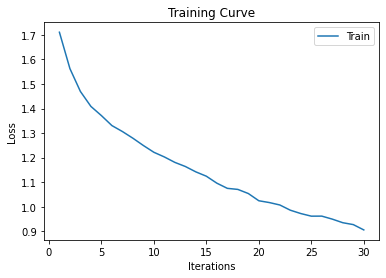

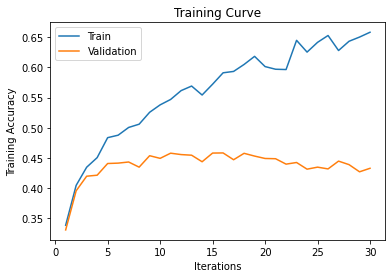

Final Training Accuracy: 0.6581131738664763
Final Validation Accuracy: 0.4328264944803166


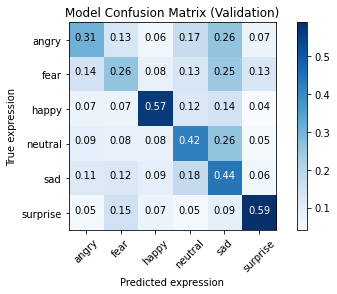

In [108]:
model2 = KLARR_NET()

if USE_CUDA:
    model2 = model2.cuda()

train(
    model2,
    train_data,
    valid_data,
    learning_rate=0.005, 
    batch_size=128,
    iterations=30
)

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET2(nn.Module):
    def __init__(self):
        super(KLARR_NET2, self).__init__()
        self.name = 'KLARR_NET2'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 15, 5)
        self.conv2 = nn.Conv2d(15, 30, 3)
        self.conv3 = nn.Conv2d(30, 45, 2)

        self.fc1 = nn.Linear(4*4*45, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1, 4*4*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.6990902870893478, Train accuracy: 0.34157443770082113 | Validation accuracy: 0.3318058737762966
Iteration 2: Train loss: 1.5635376125574112, Train accuracy: 0.3862013566583363 | Validation accuracy: 0.37283899187669234
Iteration 3: Train loss: 1.507413697513667, Train accuracy: 0.40864869689396643 | Validation accuracy: 0.39783378462820246
Iteration 4: Train loss: 1.4647392955693332, Train accuracy: 0.4299803641556587 | Validation accuracy: 0.4138721099770881
Iteration 5: Train loss: 1.425759261304682, Train accuracy: 0.4423866476258479 | Validation accuracy: 0.4211622578629452
Iteration 6: Train loss: 1.397175133228302, Train accuracy: 0.45443591574437703 | Validation accuracy: 0.4151218496146636
Iteration 7: Train loss: 1.3714496330781416, Train accuracy: 0.47929310960371296 | Validation accuracy: 0.44157467194334515
Iteration 8: Train loss: 1.3438818915323778, Train accuracy: 0.4838450553373795 | Validation accuracy: 0.44532389085607166
Iteration 9: Train 

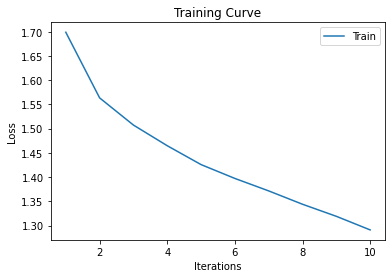

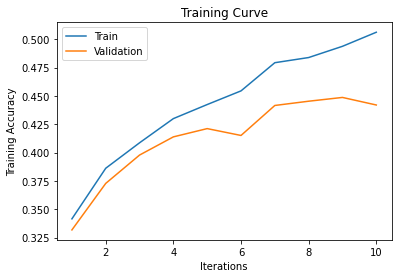

Final Training Accuracy: 0.506158514816137
Final Validation Accuracy: 0.44199125182253696


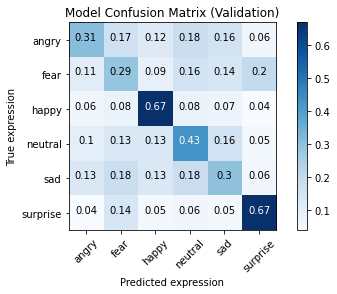

In [110]:
model3 = KLARR_NET()

if USE_CUDA:
    model3 = model3.cuda()

train(
    model3,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7554128766059875, Train accuracy: 0.2671813637986433 | Validation accuracy: 0.26556967298479484
Iteration 2: Train loss: 1.645162200385874, Train accuracy: 0.3449214566226348 | Validation accuracy: 0.33805457196417416
Iteration 3: Train loss: 1.5468283051794225, Train accuracy: 0.40311495894323457 | Validation accuracy: 0.3957508852322433
Iteration 4: Train loss: 1.4608594504269687, Train accuracy: 0.4314084255622992 | Validation accuracy: 0.4142886898562799
Iteration 5: Train loss: 1.3898538527163593, Train accuracy: 0.4688504105676544 | Validation accuracy: 0.44844823995001043
Iteration 6: Train loss: 1.3455695686015217, Train accuracy: 0.4714387718671903 | Validation accuracy: 0.43928348260779004
Iteration 7: Train loss: 1.2976167405193502, Train accuracy: 0.5114691181720814 | Validation accuracy: 0.4686523640908144
Iteration 8: Train loss: 1.2536830427971752, Train accuracy: 0.5336486968939664 | Validation accuracy: 0.48031660070818577
Iteration 9: Train 

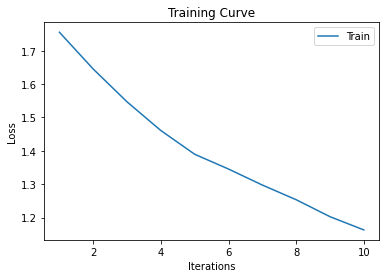

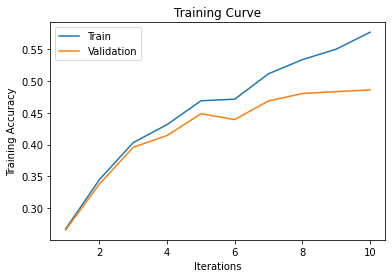

Final Training Accuracy: 0.5767583006069261
Final Validation Accuracy: 0.4859404290772756


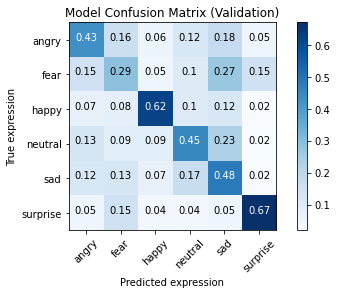

In [111]:
model4 = KLARR_NET2()

if USE_CUDA:
    model4 = model4.cuda()

train(
    model4,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.727293160828677, Train accuracy: 0.29016422706176365 | Validation accuracy: 0.2995209331389294
Iteration 2: Train loss: 1.5823511982505971, Train accuracy: 0.3991431631560157 | Validation accuracy: 0.40054155384294937
Iteration 3: Train loss: 1.4933426285331899, Train accuracy: 0.42043020349875043 | Validation accuracy: 0.4126223703395126
Iteration 4: Train loss: 1.4089937968687578, Train accuracy: 0.4617547304534095 | Validation accuracy: 0.444490731097688
Iteration 5: Train loss: 1.3412573825229297, Train accuracy: 0.4888432702606212 | Validation accuracy: 0.4605290564465736
Iteration 6: Train loss: 1.284742390567606, Train accuracy: 0.5211531595858622 | Validation accuracy: 0.4886481982920225
Iteration 7: Train loss: 1.2230543142015284, Train accuracy: 0.5302570510531953 | Validation accuracy: 0.4736513226411164
Iteration 8: Train loss: 1.1703355407172984, Train accuracy: 0.5656015708675473 | Validation accuracy: 0.4876067485940429
Iteration 9: Train loss:

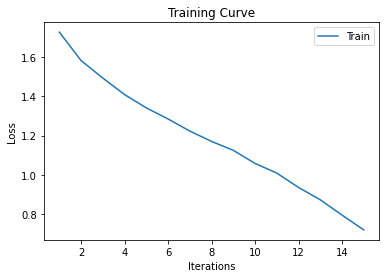

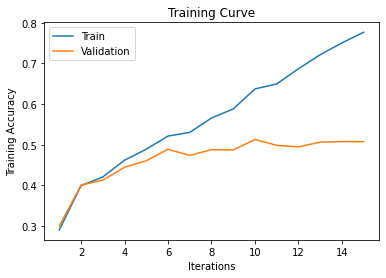

Final Training Accuracy: 0.7767761513745091
Final Validation Accuracy: 0.5073942928556551


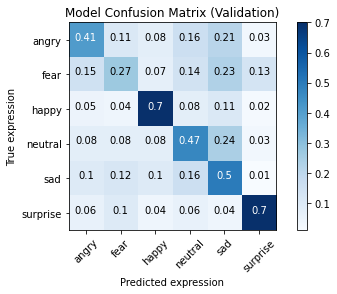

In [112]:
model5 = KLARR_NET2()

if USE_CUDA:
    model5 = model5.cuda()

train(
    model5,
    train_data,
    valid_data,
    learning_rate=0.003,
    batch_size=256,
    iterations=15
)

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET3(nn.Module):
    def __init__(self):
        super(KLARR_NET3, self).__init__()
        self.name = 'KLARR_NET3'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        self.fc1 = nn.Linear(8*8*90, 125)
        self.fc2 = nn.Linear(125, 50)
        self.fc3 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.747543683106249, Train accuracy: 0.27070689039628704 | Validation accuracy: 0.270152051655905
Iteration 2: Train loss: 1.608324714682319, Train accuracy: 0.3876740449839343 | Validation accuracy: 0.386377837950427
Iteration 3: Train loss: 1.4603383500467648, Train accuracy: 0.4438147090324884 | Validation accuracy: 0.4328264944803166
Iteration 4: Train loss: 1.375098224390637, Train accuracy: 0.4763923598714745 | Validation accuracy: 0.45698812747344303
Iteration 5: Train loss: 1.2878750874237581, Train accuracy: 0.5224473402356301 | Validation accuracy: 0.48948135805040616
Iteration 6: Train loss: 1.2260160500353032, Train accuracy: 0.5360585505176723 | Validation accuracy: 0.497396375755051
Iteration 7: Train loss: 1.1610950041900983, Train accuracy: 0.5611835058907533 | Validation accuracy: 0.5067694230368673
Iteration 8: Train loss: 1.1134298335422168, Train accuracy: 0.6054980364155659 | Validation accuracy: 0.5257238075400958
Iteration 9: Train loss: 1.

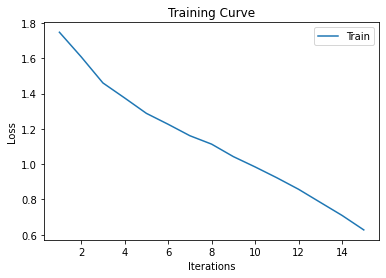

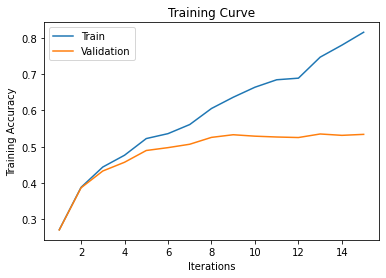

Final Training Accuracy: 0.81609246697608
Final Validation Accuracy: 0.5340554051239326


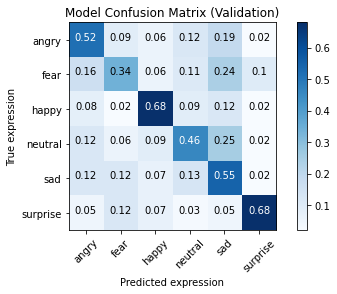

In [114]:
model6 = KLARR_NET3()

if USE_CUDA:
    model6 = model6.cuda()

train(
    model6,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET4(nn.Module):
    def __init__(self):
        super(KLARR_NET4, self).__init__()
        self.name = 'KLARR_NET4'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 49x49 (30ch)
        49x49 (30ch) --> maxpool --> 24x24 (30ch)
        24x24 (30ch) --> conv2 --> 26x26 (60ch)
        26x26 (60ch) --> maxpool --> 13x13 (60ch)
        13x13 (60ch) --> conv3 --> 16x16 (90ch)
        16x16 (90ch) --> maxpool --> 8x8 (90ch)
        '''

        self.fc1 = nn.Linear(8*8*90, 75)
        self.fc2 = nn.Linear(75, 20)
        self.fc3 = nn.Linear(20, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7429798191243953, Train accuracy: 0.2918154230631917 | Validation accuracy: 0.2999375130181212
Iteration 2: Train loss: 1.613128113475713, Train accuracy: 0.3570153516601214 | Validation accuracy: 0.35034367840033326
Iteration 3: Train loss: 1.4913762780753048, Train accuracy: 0.43270260621206713 | Validation accuracy: 0.4222037075609248
Iteration 4: Train loss: 1.4055461084300822, Train accuracy: 0.4634059264548376 | Validation accuracy: 0.43699229327223493
Iteration 5: Train loss: 1.329338719899004, Train accuracy: 0.501472688325598 | Validation accuracy: 0.47281816288273276
Iteration 6: Train loss: 1.2640125819227912, Train accuracy: 0.5177168868261335 | Validation accuracy: 0.47635909185586334
Iteration 7: Train loss: 1.2144941362467678, Train accuracy: 0.5488218493395216 | Validation accuracy: 0.4951051864194959
Iteration 8: Train loss: 1.16365700553764, Train accuracy: 0.5792127811495894 | Validation accuracy: 0.5086440324932305
Iteration 9: Train loss:

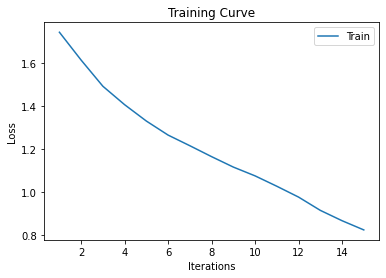

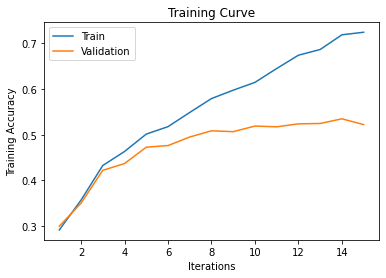

Final Training Accuracy: 0.7242948946804713
Final Validation Accuracy: 0.5221828785669652


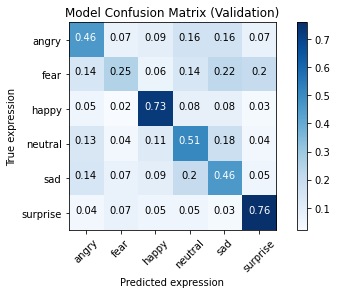

In [117]:
model7 = KLARR_NET4()

if USE_CUDA:
    model7 = model7.cuda()

train(
    model7,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET5(nn.Module):
    def __init__(self):
        super(KLARR_NET5, self).__init__()
        self.name = 'KLARR_NET5'

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_input = 4*4*256

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input, 75),
            nn.ReLU(),

            nn.Linear(75, 20),
            nn.ReLU(),

            nn.Linear(20, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, self.fc_input))
        return x

Iteration 1: Train loss: 1.7417593977668069, Train accuracy: 0.27807033202427706 | Validation accuracy: 0.2809831285148927
Iteration 2: Train loss: 1.63466070050543, Train accuracy: 0.3500089253837915 | Validation accuracy: 0.3507602582795251
Iteration 3: Train loss: 1.5252694677222858, Train accuracy: 0.39780435558729027 | Validation accuracy: 0.38846073734638614
Iteration 4: Train loss: 1.4485644833608107, Train accuracy: 0.44069082470546234 | Validation accuracy: 0.426786086232035
Iteration 5: Train loss: 1.378980746323412, Train accuracy: 0.46661906461977865 | Validation accuracy: 0.45698812747344303
Iteration 6: Train loss: 1.3380325842987408, Train accuracy: 0.4832649053909318 | Validation accuracy: 0.4580295771714226
Iteration 7: Train loss: 1.2899520221081646, Train accuracy: 0.49406461977865046 | Validation accuracy: 0.4626119558425328
Iteration 8: Train loss: 1.2544612952254035, Train accuracy: 0.5276240628347019 | Validation accuracy: 0.4774005415538429
Iteration 9: Train lo

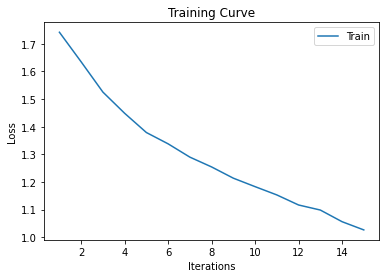

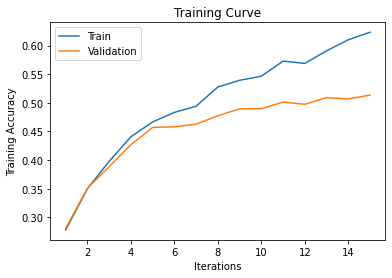

Final Training Accuracy: 0.6232149232416994
Final Validation Accuracy: 0.5134347011039366


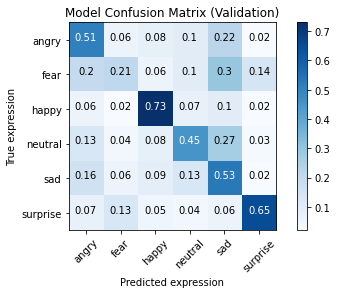

In [119]:
model8 = KLARR_NET5()

if USE_CUDA:
    model8 = model8.cuda()

train(
    model8,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [ ]:
'''
The above models had a peak Validation Accuracy of 0.535 (KLARR_NET3, model 6, iter 13).
The previous 3 KLARR_NET architectures used a combination of 3 convolutional layers and 3 linear layers.
The following models will modify the original architecture by using research and proven successful tuning strategies.
'''

In [16]:
'''
Try increasing number of convolutional layers, with depth increasing with time.
Idea is that model will learn deeper features, while width of each layer is small (3x3).
Keep kernels 3x3 but increase output channels
Have 5 convolutional and 2 linear layers
'''

class KLARR_NET6(nn.Module):
    def __init__(self):
        super(KLARR_NET6, self).__init__()
        self.name = 'KLARR_NET6'

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 150, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (150ch)
        6x6 (150ch) --> avgpool --> 3x3 (150ch)
        '''

        self.fc1 = nn.Linear(3*3*150, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.avgpool(F.relu(self.conv5(x)))

        # Linear layers
        x = x.view(-1,3*3*150)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7728111405264249, Train accuracy: 0.2173621959384066 | Validation accuracy: 0.2257862945219746
Iteration 2: Train loss: 1.7445670312101191, Train accuracy: 0.2424458826154876 | Validation accuracy: 0.2368256613205582
Iteration 3: Train loss: 1.731725660237399, Train accuracy: 0.2556572193706762 | Validation accuracy: 0.25057279733388876
Iteration 4: Train loss: 1.6756295534697445, Train accuracy: 0.33385405043517075 | Validation accuracy: 0.32014163715892524
Iteration 5: Train loss: 1.572693939913403, Train accuracy: 0.38991296585583574 | Validation accuracy: 0.3672151635076026
Iteration 6: Train loss: 1.4484640535983173, Train accuracy: 0.4374469984378487 | Validation accuracy: 0.42053738804415747
Iteration 7: Train loss: 1.3666839030655948, Train accuracy: 0.4760098192367775 | Validation accuracy: 0.44094980212455737
Iteration 8: Train loss: 1.3076586384664883, Train accuracy: 0.5127426913635349 | Validation accuracy: 0.4751093522182879
Iteration 9: Train l

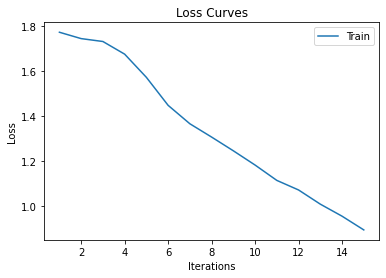

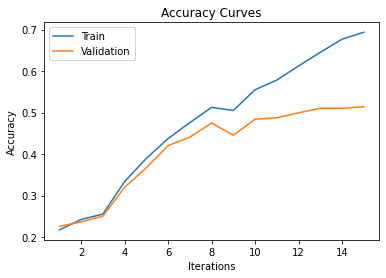

Final Training Accuracy: 0.6937290783307297
Final Validation Accuracy: 0.5140595709227245


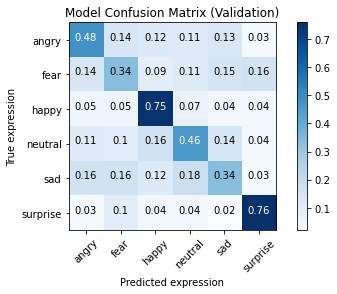

In [17]:
model6a = KLARR_NET6()

if USE_CUDA:
    model6a = model6a.cuda()

train(
    model6a,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

Iteration 1: Train loss: 1.783124249089848, Train accuracy: 0.19535817897790672 | Validation accuracy: 0.19204332430743595
Iteration 2: Train loss: 1.752325570041483, Train accuracy: 0.23106449453247044 | Validation accuracy: 0.24203290981045616
Iteration 3: Train loss: 1.7219474898143248, Train accuracy: 0.3025217585360411 | Validation accuracy: 0.2984794834409498
Iteration 4: Train loss: 1.6495869539000771, Train accuracy: 0.340459718812765 | Validation accuracy: 0.3224328264944803
Iteration 5: Train loss: 1.6010050434957852, Train accuracy: 0.3637580897121178 | Validation accuracy: 0.340970631118517
Iteration 6: Train loss: 1.547825183380734, Train accuracy: 0.3740236554340549 | Validation accuracy: 0.34763590918558634
Iteration 7: Train loss: 1.5215801014141603, Train accuracy: 0.39959830395001117 | Validation accuracy: 0.3576338262861904
Iteration 8: Train loss: 1.492807767607949, Train accuracy: 0.40241017629993303 | Validation accuracy: 0.36659029368881485
Iteration 9: Train los

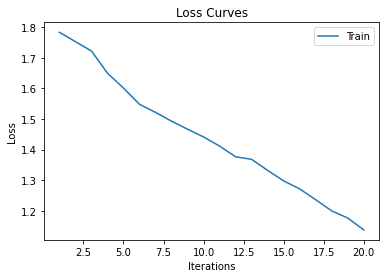

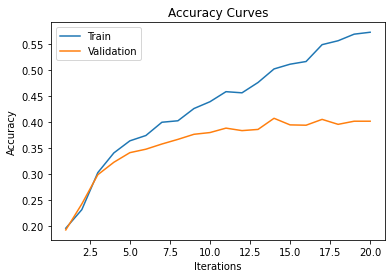

Final Training Accuracy: 0.5730863646507476
Final Validation Accuracy: 0.40158300354092896


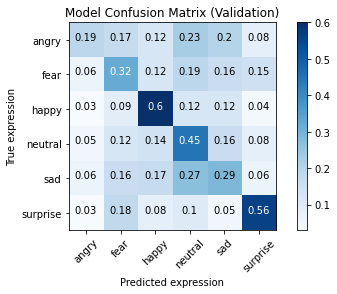

In [19]:
'''
Improvement between epochs, but slow.
Increase learning rate to reach min faster.
Increase number of iterations.
'''

model6b = KLARR_NET6()

if USE_CUDA:
    model6b = model6b.cuda()

train(
    model6b,
    train_data,
    valid_data,
    learning_rate=0.005,
    batch_size=256,
    iterations=20
)

In [16]:
'''
Use batch normalization layers to try to improve accuracy and speed up training.
Increase number of channels in final output layer.
Decrease learning rate to 0.001.

Could later use weight decay or dropout layers if we notice overfitting.
'''

class KLARR_NET7(nn.Module):
    def __init__(self):
        super(KLARR_NET7, self).__init__()
        self.name = 'KLARR_NET7'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7600756707516583, Train accuracy: 0.244275831287659 | Validation accuracy: 0.24828160799833368
Iteration 2: Train loss: 1.6991226185451855, Train accuracy: 0.3177415755411738 | Validation accuracy: 0.31785044782337013
Iteration 3: Train loss: 1.5396844853054394, Train accuracy: 0.4274045971881277 | Validation accuracy: 0.40970631118516976
Iteration 4: Train loss: 1.3899957185441798, Train accuracy: 0.47931265342557466 | Validation accuracy: 0.44803166007081857
Iteration 5: Train loss: 1.2995080717585303, Train accuracy: 0.5024324927471546 | Validation accuracy: 0.45448864819829204
Iteration 6: Train loss: 1.218426845290444, Train accuracy: 0.5352823030573532 | Validation accuracy: 0.4869818787752552
Iteration 7: Train loss: 1.1484458500688726, Train accuracy: 0.5612586476232984 | Validation accuracy: 0.4957300562382837
Iteration 8: Train loss: 1.076690640639175, Train accuracy: 0.624637357732649 | Validation accuracy: 0.5196833992918142
Iteration 9: Train los

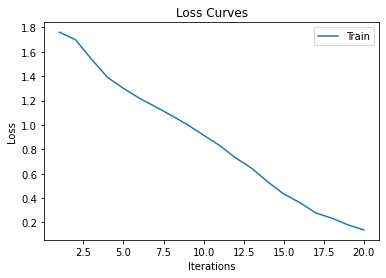

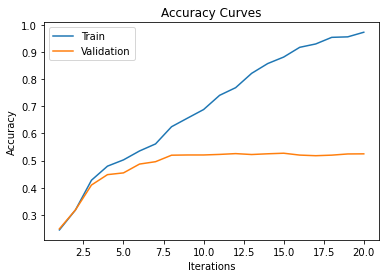

Final Training Accuracy: 0.9729078330729748
Final Validation Accuracy: 0.5246823578421163


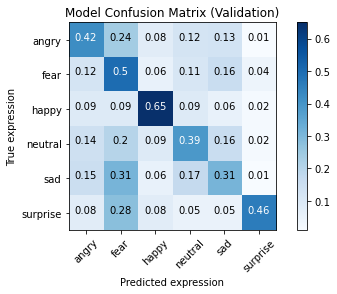

In [25]:
model7a = KLARR_NET7()

if USE_CUDA:
    model7a = model7a.cuda()

train(
    model7a,
    train_data,
    valid_data,
    learning_rate=0.001,
    batch_size=256,
    iterations=20
)

'''
This model clearly underfits and does not improve after 8 iterations
'''

Iteration 1: Train loss: 1.7583813674070619, Train accuracy: 0.25360410622628876 | Validation accuracy: 0.24932305769631327
Iteration 2: Train loss: 1.6253912868824871, Train accuracy: 0.3715688462396786 | Validation accuracy: 0.35263486773588837
Iteration 3: Train loss: 1.4571770761500706, Train accuracy: 0.4352153537156885 | Validation accuracy: 0.4169964590710269
Iteration 4: Train loss: 1.3286612887274136, Train accuracy: 0.5056460611470653 | Validation accuracy: 0.4730264528223287
Iteration 5: Train loss: 1.256588184020736, Train accuracy: 0.5309082794019192 | Validation accuracy: 0.4815663403457613
Iteration 6: Train loss: 1.1909550001675433, Train accuracy: 0.5612586476232984 | Validation accuracy: 0.5021870443657571
Iteration 7: Train loss: 1.1411322040314025, Train accuracy: 0.5872349921892435 | Validation accuracy: 0.5109352218287857
Iteration 8: Train loss: 1.1101342724128203, Train accuracy: 0.6195045748716804 | Validation accuracy: 0.522807748385753
Iteration 9: Train loss

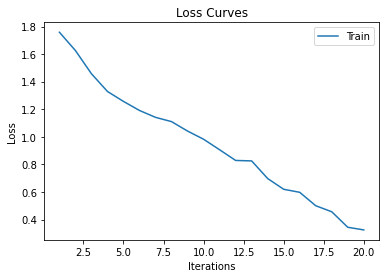

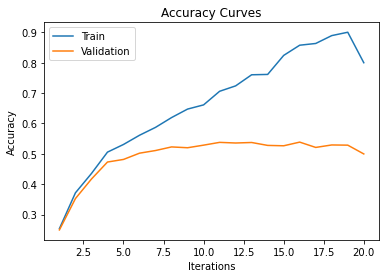

Final Training Accuracy: 0.8002677973666592
Final Validation Accuracy: 0.49968756509060613


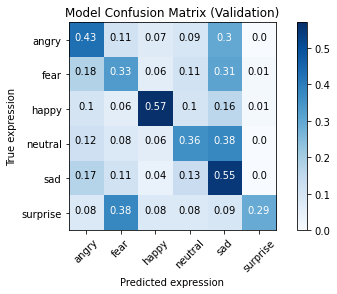

In [43]:
'''
Current best model: @ iteration 16, Validation accuracy: 0.5386377837950427
'''

model7d = KLARR_NET7()

if USE_CUDA:
    model7d = model7d.cuda()

train(
    model7d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    iterations=20
)

In [7]:
'''
Increasing num of conv channels and adding batch normalization worked well
Training accuracy kept improving (up to 90%) but validation accuracy plateaued.

Exeriment with weight decay and dropout layers to try to resolve this overfitting issue.
'''

class KLARR_NET8(nn.Module):
    def __init__(self):
        super(KLARR_NET8, self).__init__()
        self.name = 'KLARR_NET8'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.dropout_50 = nn.Dropout2d()
        self.dropout_25 = nn.Dropout2d(p=0.25)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.dropout_50(x)
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))
        x = self.dropout_25(x)

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7735994031483477, Train accuracy: 0.19336843984291324 | Validation accuracy: 0.19933347219329306
Iteration 2: Train loss: 1.789115392348983, Train accuracy: 0.180872902534809 | Validation accuracy: 0.18433659654238702
Iteration 3: Train loss: 1.781958317892118, Train accuracy: 0.18993216708318458 | Validation accuracy: 0.19787544261612164
Iteration 4: Train loss: 1.782750397243283, Train accuracy: 0.191181720813995 | Validation accuracy: 0.18246198708602374
Iteration 5: Train loss: 1.7676237401637165, Train accuracy: 0.19452873973580864 | Validation accuracy: 0.19933347219329306
Iteration 6: Train loss: 1.7590921141884543, Train accuracy: 0.2079614423420207 | Validation accuracy: 0.2114142886898563
Iteration 7: Train loss: 1.7540346045385709, Train accuracy: 0.23330953230988932 | Validation accuracy: 0.23557592168298272
Iteration 8: Train loss: 1.7493576299060474, Train accuracy: 0.23665655123170296 | Validation accuracy: 0.23245157258904395
Iteration 9: Trai

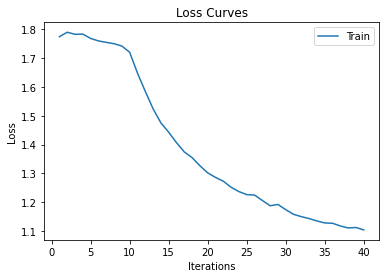

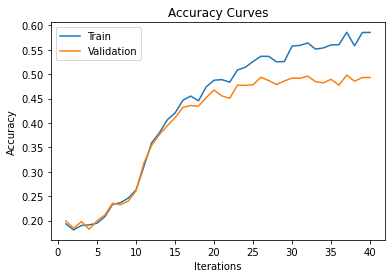

Final Training Accuracy: 0.5857729382363441
Final Validation Accuracy: 0.4934388669027286


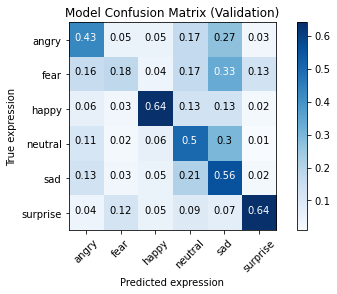

In [8]:
model8c = KLARR_NET8()

if USE_CUDA:
    model8c = model8c.cuda()

train(
    model8c,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.001,
    dropout=True,
    iterations=40
)

Iteration 1: Train loss: 1.766847931525924, Train accuracy: 0.21514637629418065 | Validation accuracy: 0.2189127265153093
Iteration 2: Train loss: 1.758080809631131, Train accuracy: 0.22081399500178508 | Validation accuracy: 0.22432826494480318
Iteration 3: Train loss: 1.7323379096659748, Train accuracy: 0.26740449839343094 | Validation accuracy: 0.27910851905852946
Iteration 4: Train loss: 1.614698892289942, Train accuracy: 0.3548286326312031 | Validation accuracy: 0.34888564882316186
Iteration 5: Train loss: 1.4978699806061657, Train accuracy: 0.4218582649053909 | Validation accuracy: 0.4044990626952718
Iteration 6: Train loss: 1.3959864269603381, Train accuracy: 0.448545162441985 | Validation accuracy: 0.4399083524265778
Iteration 7: Train loss: 1.323408192531629, Train accuracy: 0.5010710460549803 | Validation accuracy: 0.474692772339096
Iteration 8: Train loss: 1.2620942416516217, Train accuracy: 0.5246340592645484 | Validation accuracy: 0.48802332847323476
Iteration 9: Train loss

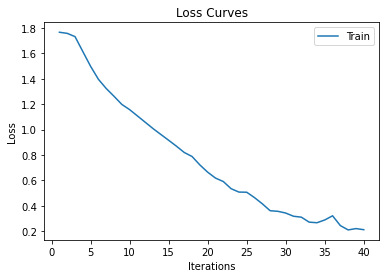

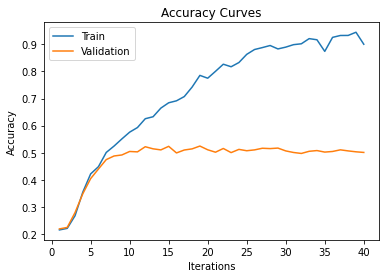

Final Training Accuracy: 0.9004373438057837
Final Validation Accuracy: 0.5011455946677775


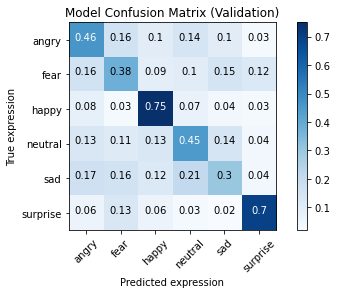

In [9]:
model8d = KLARR_NET8()

if USE_CUDA:
    model8d = model8d.cuda()

train(
    model8d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.0001,
    dropout=True,
    iterations=40
)

In [ ]:
'''
Done architecture tuning. Time for hyperparameter tuning.
Tune DECAY, BATCH SIZE, and LR for current best (8? = ? @ iter ?)
'''

In [ ]:
'''
Can further implement early stop based on validation loss, and reduce lr as training goes on
Could also perform transfer learning
'''